Vehicle velocity model with slope: closed loop model.

Currently under development.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy import constants

In [4]:
def eval_model(model, xs):
    return np.array(list(map(model, xs)))

$\frac{dv(t)}{dt} = \frac{1}{m} [ F_p K_c (v_{SP}(t) - v(t)) + \frac{K_c}{\tau_i} \int e(t) dt - \frac{1}{2} \rho A C_d v(t)^2 ] - g sin(\theta)$

In [5]:
# Mass (car + load), kg
m = 700

# Thrust parameter, (N / %pedal)
F_p = 30

# Air density, kg/m^3
rho = 1.225 

# vehicle cross-sectional area (m^2)
A = 5

# Drag coefficient
C_d = 0.24

# Controller gain and integration constant
K_c = 13.
tau_i = 25.


class Vehicle:
    
    def __init__(self, setpoint_func, disturbance_func):
        
        self.setpoint_func = setpoint_func
        self.disturbance_func = disturbance_func
        
        self.accumulated_error = 0
        self.t_prev = 0
        
        self.error_history = []
        self.error_accumulation_history = []

    def model(self, v, t):

        v_sp = self.setpoint_func(t)
        theta = self.disturbance_func(t)
        
        error = v_sp - v
        increment = error * (t - self.t_prev)
        self.accumulated_error += increment
        
        self.error_history.append(error[0])
        self.error_accumulation_history.append(self.accumulated_error[0])

        drive = F_p * K_c * error + (K_c / tau_i) * self.accumulated_error
        drag = 0.5 * rho * A * C_d * (v**2)
        slope = constants.g * np.sin(theta)
        
        self.t_prev = t

        return (1. / m) * (drive - drag) - slope
    

In [6]:
def setpoint_strategy(t):
    
    if t < 25:
        return 0
    
    if t >= 25 and t < 100:
        return 10
    
    if t >= 100 and t < 150:
        return 15
    
    if t >= 150:
        return 10
    
    
def no_slope(t):
    return 0

In [7]:
t = np.linspace(0, 200, 100)

vehicle = Vehicle(setpoint_strategy, no_slope)

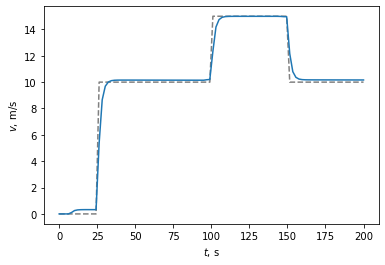

In [8]:
initial = 0

v_sim = odeint(vehicle.model, initial, t)

plt.plot(t, eval_model(setpoint_strategy, t), '--', color='gray')
plt.plot(t, v_sim)

plt.xlabel('$t$, s')
plt.ylabel('$v$, m/s')
plt.show()

In [9]:
error_history = eval_model(setpoint_strategy, t) - v_sim.reshape(-1)

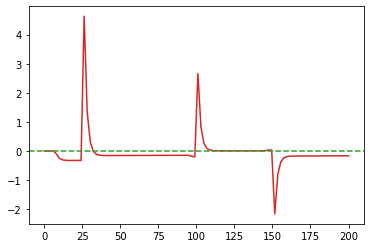

In [10]:
plt.plot(t, error_history, color='tab:red')
plt.axhline(0, linestyle='--', color='tab:green')
plt.show()

In [11]:
# test
def accumulate_error(t, error_history):
    
    return np.sum(np.diff(t) * error_history[1:])

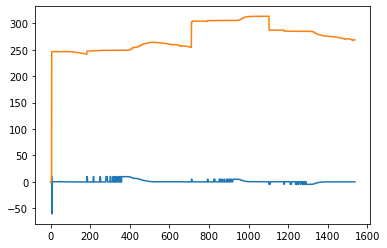

In [12]:
plt.plot(vehicle.error_history)
plt.plot(vehicle.error_accumulation_history)
plt.show()